# 7. Digitization of MESH surface in 3D space

This notebook demonstrates how to use digitize_general on a point network, like MESH.

## Load packages

In [1]:
import sys
import spateo as st

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

import pyvista as pv
pv.start_xvfb()

2024-08-17 14:07:29.320758: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 14:07:29.352262: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 14:07:29.352292: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 14:07:29.352312: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 14:07:29.358475: I tensorflow/core/platform/cpu_feature_g

## Data source

**adata_tube:** A manually extracted subset of E11.5 mouse embryo near diencephalic neural tube

In [3]:
adata_tube=st.read_h5ad("adata_dien_clip.h5ad")

## Construct MESH for an diencephalic subset of the E11.5 mouse embryo

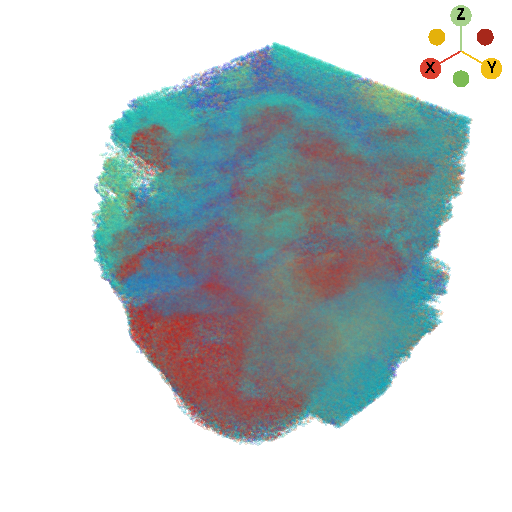

In [4]:
pc_model, _ = st.tdr.construct_pc(adata=adata_tube.copy(),spatial_key="spatial",groupby="mapped_celltype", key_added="mapped_celltype",colormap="rainbow")

st.pl.three_d_plot(
    model=pc_model,
    key="mapped_celltype",
    model_style="points",
    model_size=3,
    jupyter="static",opacity=0.2,
)

In [5]:
# Subset the point cloud to reduce memory consumption
if pc_model.n_points > 500000:
        np.random.seed(19491001)
        sampling = np.random.choice(
            np.asarray(pc_model.point_data["obs_index"]),
            size=100000, #decrease this if memory limit exceeded
            replace=False,
        )
        downsampling_pc_model = pc_model.extract_points(np.isin(np.asarray(pc_model.point_data["obs_index"]), sampling))
else:
    downsampling_pc_model = pc_model.copy()

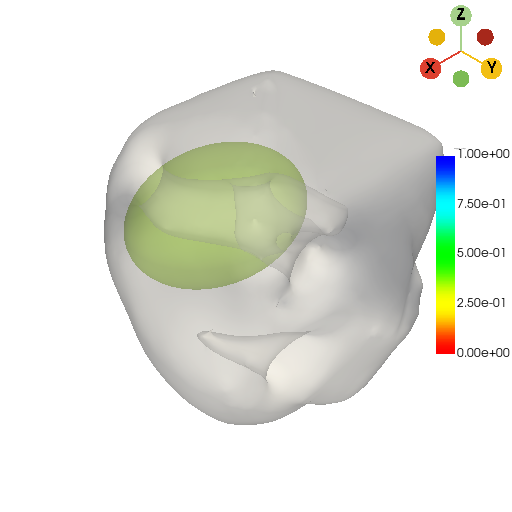

In [8]:
# Here we use a manually defined ellipsoid to cut off the inner surface of the neural tube.
# Use interactive or any selection methods in your case.

ellipsoid = pv.ParametricEllipsoid(xradius = 190 , yradius = 139 , zradius = 120)
ellipsoid.point_data["mapped_celltype"] = np.asarray(["Ellipsoid"] * ellipsoid.n_points)
ellipsoid.points  = np.asarray(ellipsoid.points) - np.asarray(np.asarray(ellipsoid.center) - np.asarray(pc_model.center) + np.array([-25, 65, -80]))

st.pl.three_d_plot(
    model=st.tdr.collect_models([ellipsoid, mesh_model]),
    key="mapped_celltype",
    model_style=["surface", "surface"],
    colormap=["yellowgreen", "gainsboro"],
    opacity=[0.6, 0.6],
    model_size=3,
    jupyter="static",
)

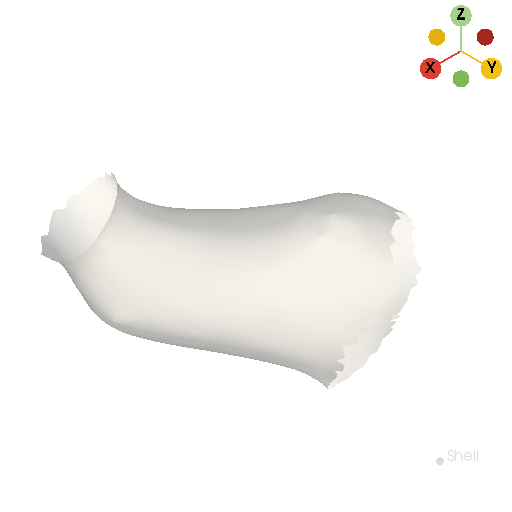

In [14]:
select_mesh_model = mesh_model.select_enclosed_points(ellipsoid, check_surface=False)
inside_mesh_model = select_mesh_model.threshold(0.5, scalars="SelectedPoints").extract_surface()

st.pl.three_d_plot(
    model=st.tdr.collect_models([inside_mesh_model]),
    key="mapped_celltype",
    model_style=["surface", "points"],
    model_size=3,
    jupyter="static",
)

## Digitization on MESH

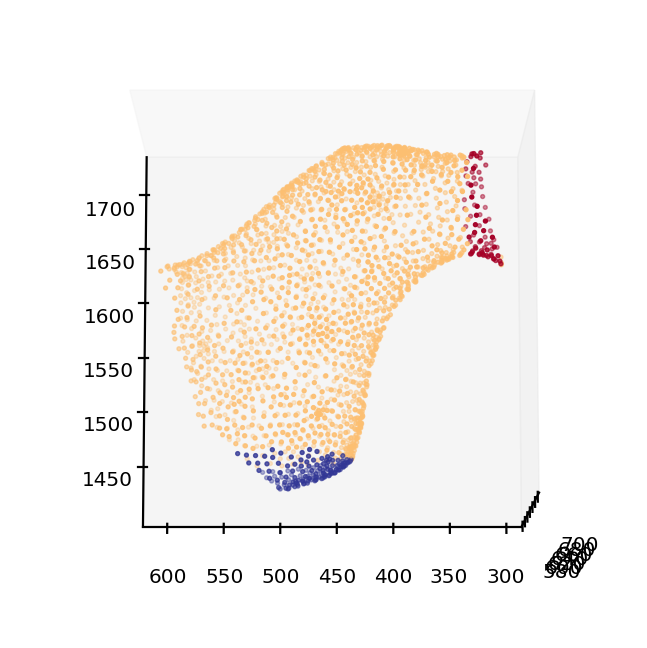

In [68]:
# Here we use a coordinate cutoff to demonstrate the selection of digitization boundary.
# Use interactive or any selection methods in your case.

df_mesh_net = pd.DataFrame({
    'x':np.array(inside_mesh_model.points)[:,0].flatten(),
    'y':np.array(inside_mesh_model.points)[:,1].flatten(),
    'z':np.array(inside_mesh_model.points)[:,2].flatten(),
    # Here we use a coordinate cutoff for demonstration. Use interactive selection in your case.
    'point':1+((np.abs(np.array(inside_mesh_model.points)[:,1] - 325)<15).astype(int)-
    2*(np.abs(np.array(inside_mesh_model.points)[:,0] - 1420)<25).astype(int))
})

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(
    xs=df_mesh_net.x,
    ys=df_mesh_net.y,
    zs=df_mesh_net.z,
    c=df_mesh_net.point,
    s=2,
    cmap="RdYlBu_r",
)
ax.grid(False)
ax.view_init(elev=80, azim=180)

In [27]:
# Here we use a coordinate cutoff for demonstration. Use interactive or any selection methods in your case.
boundary_lower = np.where(np.abs(np.array(inside_mesh_model.points)[:,0] - 1420)<25)
boundary_upper = np.where(np.abs(np.array(inside_mesh_model.points)[:,1] - 325)<15)

In [ ]:
# Extract the adjacency matrix from mesh network
adj_mtx = np.zeros((len(inside_mesh_model.points), len(inside_mesh_model.points)))

faces = inside_mesh_model.faces
ind = 0
face_degrees = []

while ind < len(faces):
    adj_mtx[faces[ind+1], faces[ind+faces[ind]]] = 1
    adj_mtx[faces[ind+faces[ind]], faces[ind+1]] = 1
    
    face_degrees.append(faces[ind])
    
    for i in range(1, faces[ind]):
        ind = ind + 1
        adj_mtx[faces[ind], faces[ind+1]] = 1
        adj_mtx[faces[ind+1], faces[ind]] = 1
    
    ind = ind + 2

conv_mtx = np.apply_along_axis(lambda x: x/np.sum(x), axis=0, arr=adj_mtx)

In [ ]:
# Perform digitization on the mesh network
st.dd.utils.digitize_general(
    pc=inside_mesh_model.points,
    adj_mtx=conv_mtx,
    boundary_lower=boundary_lower,
    boundary_upper=boundary_upper,
)

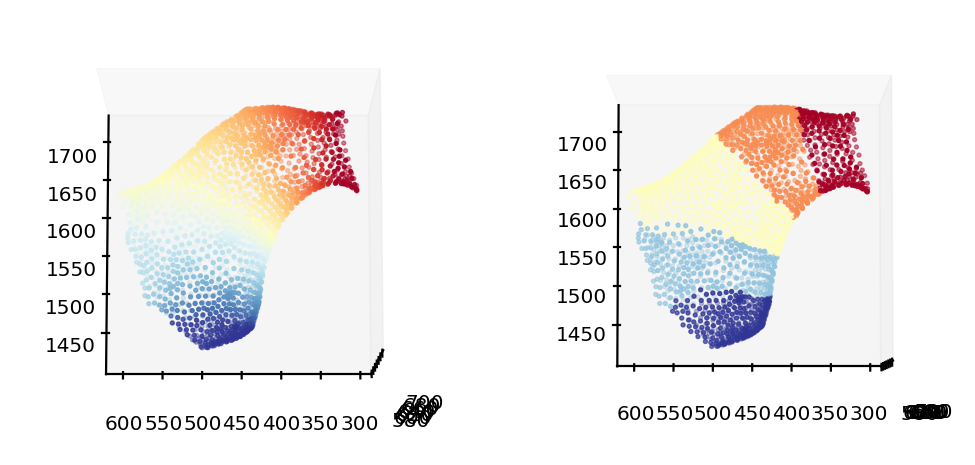

In [75]:
# Visualize the digitized mesh

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d"})

ax[0].scatter(
    xs=df_mesh_net.x,
    ys=df_mesh_net.y,
    zs=df_mesh_net.z,
    c=grid_field,
    s=2,
    cmap="RdYlBu_r",
)
ax[0].grid(False)
ax[0].view_init(elev=80, azim=180)

ax[1].scatter(
    xs=df_mesh_net.x,
    ys=df_mesh_net.y,
    zs=df_mesh_net.z,
    c=(grid_field - 1) // 20,
    s=2,
    cmap="RdYlBu_r",
)
ax[1].grid(False)
ax[1].view_init(elev=85, azim=180)

In [ ]:
pts_df = pd.DataFrame({
        'x':np.array(inside_mesh_model.points)[:,0],
        'y':np.array(inside_mesh_model.points)[:,1],
        'z':np.array(inside_mesh_model.points)[:,2],
        'point':np.logical_and(grid_field>50, grid_field<70),
    })

In [ ]:
fig = px.scatter_3d(
    pts_df[pts_df['point']],
    x='x', y='y', z='z', 
    color=(pts_df[pts_df['point']]['y']+pts_df[pts_df['point']]['x'])>2180,
    opacity=0.9,
)
fig.update_traces(marker_size = 2)

fig.show()
#fig.write_html("./heart/Heart.cellbin_spatialDomain.scVI_prediction.ShendureRef2.HQ_MT_r1000_pro.v230824.regist.3D.html")

In [ ]:
fig = px.scatter_3d(
    pts_df[pts_df['point']],
    x='x', y='y', z='z', 
    color=(pts_df[pts_df['point']]['y']+0.3*pts_df[pts_df['point']]['x'])<870,
    opacity=0.9,
)
fig.update_traces(marker_size = 2)

fig.show()
#fig.write_html("./heart/Heart.cellbin_spatialDomain.scVI_prediction.ShendureRef2.HQ_MT_r1000_pro.v230824.regist.3D.html")

In [ ]:
mask_field_orth = np.zeros(len(pts_df['point']))
mask_field_orth[np.logical_and(
    pts_df['point'],
    (pts_df['y']+0.3*pts_df['x'])<880,
)] = 1
mask_field_orth[np.logical_and(
    pts_df['point'],
    (pts_df['y']+pts_df['x'])>2180,
)] = 100
mask_field_orth
len(mask_field_orth)

In [ ]:
max_err = 1e-5
max_itr = 1e5
err = 1
itr = 0
grid_field_orth = mask_field_orth.copy()
while (err > max_err) and (itr <= max_itr):
    grid_field_pre = grid_field_orth.copy()
 
    grid_field_orth = np.matmul(grid_field_orth, conv_mtx)

    grid_field_orth = np.where(mask_field_orth != 0, mask_field_orth, grid_field_orth)
    err = np.sqrt(
        np.sum((grid_field_orth - grid_field_pre) ** 2) / np.sum(grid_field_orth**2)
    )
    if itr >= max_itr:
        lm.main_info("Max iteration reached, with L2 error at: " + str(err))
    itr = itr + 1

print("Total iteration: " + str(itr))
grid_field_orth.shape

In [ ]:
fig = px.scatter_3d(
    pts_df,
    x='x', y='y', z='z', 
    color=grid_field_orth,
    opacity=0.9,
)
fig.update_traces(marker_size = 2)

fig.show()
#fig.write_html("./heart/Heart.cellbin_spatialDomain.scVI_prediction.ShendureRef2.HQ_MT_r1000_pro.v230824.regist.3D.html")

In [ ]:
fig = px.scatter_3d(
    pts_df[pts_df['point']],
    x='x', y='y', z='z', 
    color=grid_field_orth[pts_df['point']],
    opacity=0.9,
)
fig.update_traces(marker_size = 2)

fig.show()
#fig.write_html("./heart/Heart.cellbin_spatialDomain.scVI_prediction.ShendureRef2.HQ_MT_r1000_pro.v230824.regist.3D.html")